# Local Volatility Model vs. Black-Scholes Forecasting Using Real Apple Market Data

intro/description sim 5 random strikes

In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import multiprocessing
from sklearn import metrics
#import scipy.fftpack

#from sklearn.model_selection import train_test_split
#from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
from joblib import Parallel, delayed

## Data Preprocessing

### AAPL Options Data

In [2]:
ticker = yf.Ticker("AAPL")
options_list = []
exps = ticker.options  # expiration dates

In [3]:
# get AAPL options data
for e in exps:
    opt = ticker.option_chain(e)
    opt_df = pd.concat([opt.calls, opt.puts])
    opt_df["expirationDate"] = pd.to_datetime(e)
    options_list.append(opt_df)

# combine all options into one DataFrame
options = pd.concat(options_list, ignore_index=True)

# days until expiration
today = datetime.datetime.today()
options["dte"] = (options["expirationDate"] - today).dt.days
options['T'] = options['dte'] / 365 # years until expiration (T)

# IV
options["impliedVolatility"] = options["impliedVolatility"].replace(0, np.nan)
options = options.dropna(subset=["impliedVolatility"])

# call/put labels
options["option_type"] = options["contractSymbol"].apply(
    lambda x: "Call" if "C" in x else "Put"
)
call = options[options['option_type'] == 'Call']
put = options[options['option_type'] == 'Put']

# display
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
0,AAPL250214C00100000,2025-02-05 18:29:16+00:00,100.0,129.95,0.0,0.0,0.0,0.0,NaN,0.0,0.00001,True,REGULAR,USD,2025-02-14,3,0.008219,Call
1,AAPL250214C00130000,2025-02-07 16:53:37+00:00,130.0,98.87,0.0,0.0,0.0,0.0,15.0,0.0,0.00001,True,REGULAR,USD,2025-02-14,3,0.008219,Call
2,AAPL250214C00140000,2025-02-07 17:34:59+00:00,140.0,88.52,0.0,0.0,0.0,0.0,36.0,0.0,0.00001,True,REGULAR,USD,2025-02-14,3,0.008219,Call
3,AAPL250214C00145000,2025-02-07 17:54:27+00:00,145.0,83.43,0.0,0.0,0.0,0.0,5.0,0.0,0.00001,True,REGULAR,USD,2025-02-14,3,0.008219,Call
4,AAPL250214C00150000,2025-02-07 18:00:39+00:00,150.0,78.85,0.0,0.0,0.0,0.0,72.0,0.0,0.00001,True,REGULAR,USD,2025-02-14,3,0.008219,Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,AAPL270617P00410000,2025-01-31 20:17:57+00:00,410.0,176.03,0.0,0.0,0.0,0.0,1.0,0.0,0.00001,True,REGULAR,USD,2027-06-17,856,2.345205,Put
2077,AAPL270617P00420000,2025-01-31 20:11:23+00:00,420.0,186.44,0.0,0.0,0.0,0.0,1.0,0.0,0.00001,True,REGULAR,USD,2027-06-17,856,2.345205,Put
2078,AAPL270617P00430000,2025-01-31 20:11:23+00:00,430.0,196.42,0.0,0.0,0.0,0.0,1.0,0.0,0.00001,True,REGULAR,USD,2027-06-17,856,2.345205,Put
2079,AAPL270617P00440000,2025-02-07 14:43:51+00:00,440.0,206.93,0.0,0.0,0.0,0.0,5.0,0.0,0.00001,True,REGULAR,USD,2027-06-17,856,2.345205,Put


In [4]:
# save files
options.to_csv("nvda_options.csv")
call.to_csv("nvda_call.csv")
put.to_csv("nvda_put.csv")

In [5]:
# pick 50 random strikes to simulate
'''
strike_series = call["strike"]

selected_strikes = strike_series[(strike_series >= 50) & (strike_series <= 300)].sample(50, random_state=26).values 
call_selected = call[call['strike'].isin(selected_strikes)]
print(min(call['dte']))
print(max(call['dte']))

'''

'\nstrike_series = call["strike"]\n\nselected_strikes = strike_series[(strike_series >= 50) & (strike_series <= 300)].sample(50, random_state=26).values \ncall_selected = call[call[\'strike\'].isin(selected_strikes)]\nprint(min(call[\'dte\']))\nprint(max(call[\'dte\']))\n\n'

In [6]:
# sample a range of values
strike_series = call["strike"]
dte_series = call["dte"]

selected_strikes = strike_series[(strike_series >= 50) & (strike_series <= 300)].sample(50, random_state=26).values
selected_dte = dte_series.sample(50, random_state=26).values  # Sample 50 random expiration dates

call_selected = call[
    (call['strike'].isin(selected_strikes)) & 
    (call['dte'].isin(selected_dte))
]

print(call_selected)
print("Min DTE:", min(call_selected['dte']))
print("Max DTE:", max(call_selected['dte']))
print("Strike range:", min(call_selected['strike']), "to", max(call_selected['strike']))
print("DTE range:", min(call_selected['dte']), "to", max(call_selected['dte']))


           contractSymbol             lastTradeDate  strike  lastPrice  bid  \
1     AAPL250214C00130000 2025-02-07 16:53:37+00:00   130.0      98.87  0.0   
2     AAPL250214C00140000 2025-02-07 17:34:59+00:00   140.0      88.52  0.0   
8     AAPL250214C00170000 2025-02-07 15:17:28+00:00   170.0      60.27  0.0   
9     AAPL250214C00175000 2025-02-07 18:19:29+00:00   175.0      54.27  0.0   
10    AAPL250214C00180000 2025-02-07 20:23:42+00:00   180.0      48.40  0.0   
...                   ...                       ...     ...        ...  ...   
2016  AAPL270617C00250000 2025-02-07 17:15:08+00:00   250.0      35.00  0.0   
2017  AAPL270617C00260000 2025-02-07 20:39:56+00:00   260.0      29.45  0.0   
2018  AAPL270617C00270000 2025-02-07 19:46:42+00:00   270.0      26.23  0.0   
2019  AAPL270617C00280000 2025-02-07 19:21:52+00:00   280.0      22.50  0.0   
2021  AAPL270617C00300000 2025-02-07 20:42:38+00:00   300.0      16.80  0.0   

      ask  change  percentChange  volume  openInter

Data collected on: Feburary Xth, 2025:

In [7]:
# reread files (if I don't want to get new data)
options = pd.read_csv("data/nvda_options.csv")
call = pd.read_csv("data/nvda_call.csv")
put = pd.read_csv("data/nvda_put.csv")

### AAPL Stock Data

As of January 31st, 2025, AAPL stock price is: $120.07

In [8]:
today_price = ticker.history(period="1d")["Close"].iloc[-1]  
stock = ticker.history()
print(f"Current AAPL Price: ${today_price.round(2)}")
stock

Current NVDA Price: $227.63


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-08 00:00:00-05:00,241.919998,243.710007,240.050003,242.699997,37628900,0.0,0.0
2025-01-10 00:00:00-05:00,240.009995,240.160004,233.000000,236.850006,61710900,0.0,0.0
2025-01-13 00:00:00-05:00,233.529999,234.669998,229.720001,234.399994,49630700,0.0,0.0
2025-01-14 00:00:00-05:00,234.750000,236.119995,232.470001,233.279999,39435300,0.0,0.0
2025-01-15 00:00:00-05:00,234.639999,238.960007,234.429993,237.869995,39832000,0.0,0.0
2025-01-16 00:00:00-05:00,237.350006,238.009995,228.029999,228.259995,71759100,0.0,0.0
2025-01-17 00:00:00-05:00,232.119995,232.289993,228.479996,229.979996,68488300,0.0,0.0
2025-01-21 00:00:00-05:00,224.000000,224.419998,219.380005,222.639999,98070400,0.0,0.0
2025-01-22 00:00:00-05:00,219.789993,224.119995,219.789993,223.830002,64126500,0.0,0.0


## Implied Volatility Surface

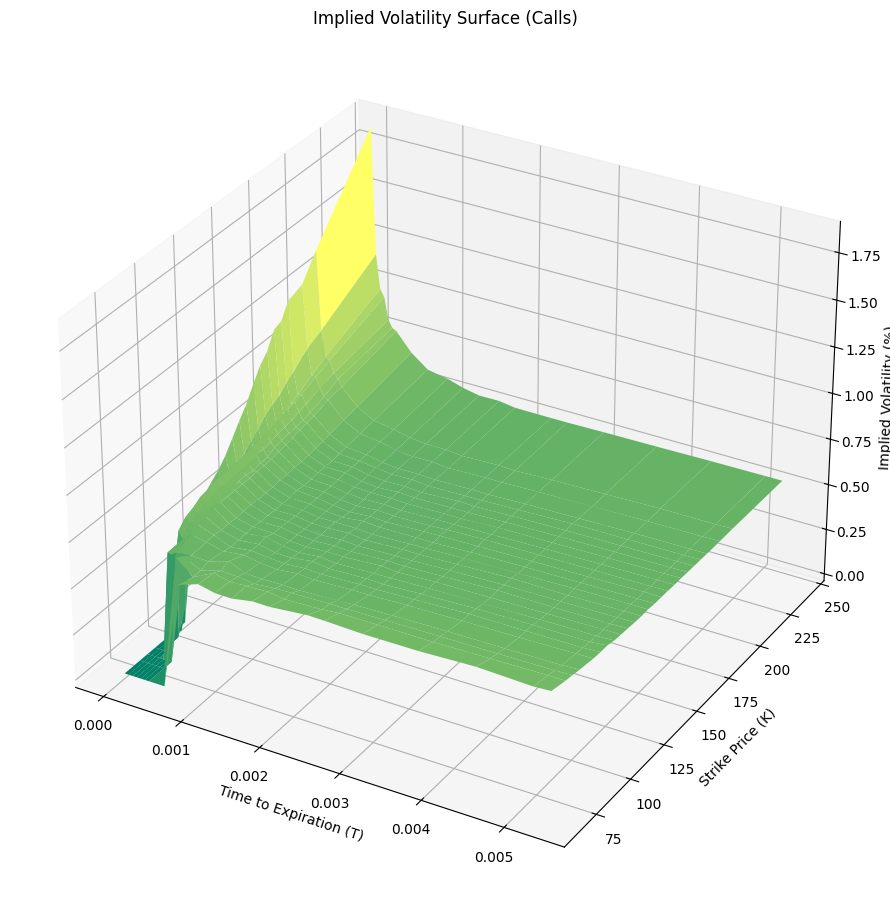

In [9]:
# calls
K, T, iv = call['strike'],  call['T'], call['impliedVolatility']
values = call[['strike', 'T', 'impliedVolatility']].pivot_table(values='impliedVolatility',index='strike',columns='T').dropna()
x, y, z = values.columns, values.index, values.values
X, Y = np.meshgrid(x, y)
#grid_points = (K, T)
#interp_iv = interpn(vals_array[1:3], iv, grid_points ,bounds_error=False, fill_value=None)
###
#vals_array

fig = plt.figure(figsize=(25,9))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='summer')

# labels and title
plt.tight_layout()
ax.set_ylabel('Strike Price (K)')
ax.set_xlabel('Time to Expiration (T)')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Implied Volatility Surface (Calls)')
#ax.view_init(elev=30, azim=240)
plt.show()

## Monte Carlo Simulations of SDE's for Black-Scholes and Heston Models

(description) while closed form solution is better for BS model, i want to be consistent with heston

In [10]:
# Universal Parameters (both models)
N_paths = 1000    # Number of Monte Carlo simulations (INCREASE LATER)
dt = 1/251       # 1 trading day time step
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility (BS), Volatility of Volatility (Heston)

# Heston Parameters
v0 = sigma**2    # Initial variance
kappa = 2        # Mean reversion speed
theta = 0.04     # Long-term variance
rho = -0.7       # Correlation between stock and volatility

# Test Parameters
K = 100          # Strike price
T = 1           # Time to maturity (1/2 year)
S0 = 100         # Initial stock price

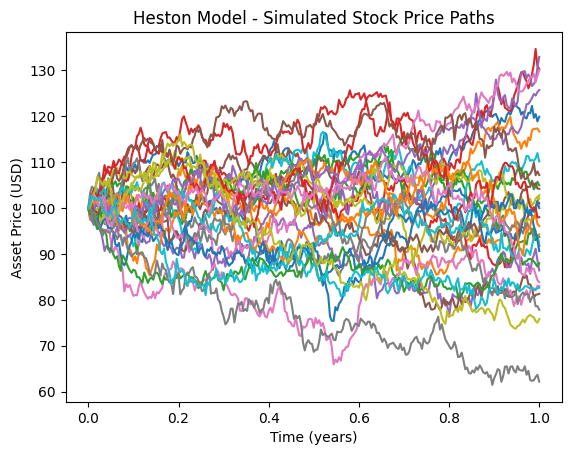

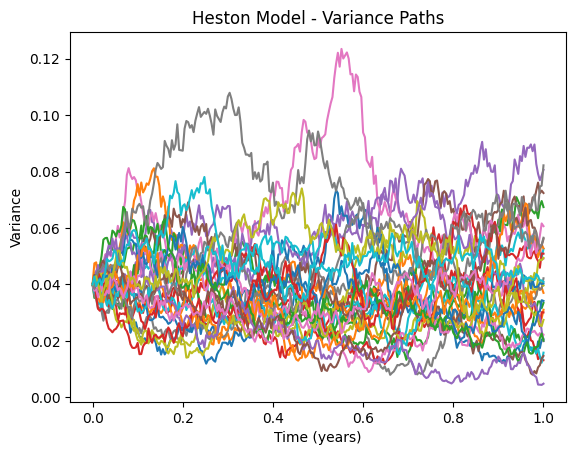

In [11]:
# Heston Model Monte Carlo Simulation
def heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0):
    np.random.seed(26)
    N_steps = int(T / dt)
    t_grid = np.linspace(0, T, N_steps)

    S_paths = np.zeros((N_paths, N_steps))
    v_paths = np.zeros((N_paths, N_steps))

    S_paths[:, 0] = S0
    v_paths[:, 0] = v0

    # Iterate Through Time Steps
    for t in range(1, N_steps):
        dW_S = np.random.randn(N_paths) * np.sqrt(dt)
        dW_v = rho * dW_S + np.sqrt(1 - rho**2) * np.random.randn(N_paths) * np.sqrt(dt)
        
        v_t = v_paths[:, t-1]
        S_t = S_paths[:, t-1]

        # Volatility Process
        dv = kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t) * dW_v
        v_paths[:, t] = np.maximum(v_t + dv, 0)  # Ensure non-negative variance

        # Asset Price Process
        dS = r * S_t * dt + np.sqrt(v_paths[:, t]) * S_t * dW_S
        S_paths[:, t] = S_t + dS

    S_final = S_paths[:, -1]
    # Calculate Call Price
    payoff = np.maximum(S_final - K, 0)
    C = np.exp(-r * T) * np.mean(payoff)

    return t_grid, S_paths, v_paths, C

# Run Heston Monte Carlo
t_grid, S_paths, v_paths, C = heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0)


# plot stock price paths
for i in range(30):
    plt.plot(t_grid, S_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Asset Price (USD)')
    plt.title('Heston Model - Simulated Stock Price Paths')
plt.show()
# plot variance paths
for i in range(30):
    plt.plot(t_grid, v_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Variance')
    plt.title('Heston Model - Variance Paths')
plt.show()

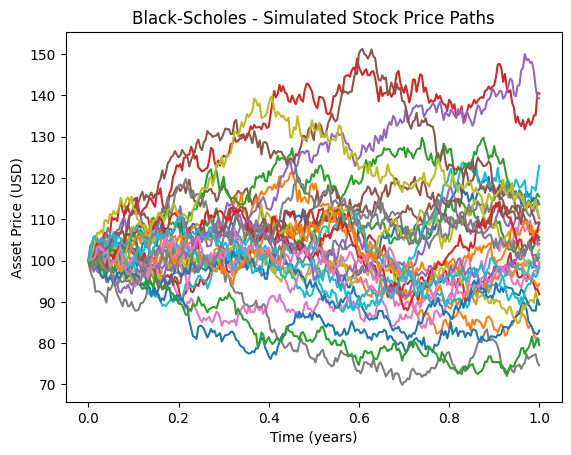

In [12]:
# Black-Scholes Model Monte Carlo Simulation
def bs_mc(K, T, N_paths, r, sigma, dt, S0):
    np.random.seed(26)
    N_steps = int(T / dt)
    t_grid = np.linspace(0, T, N_steps)

    S_paths = np.zeros((N_paths, N_steps))
    S_paths[:, 0] = S0

    # Iterate Through Time Steps
    for t in range(1, N_steps):
        
        dW_S = np.random.randn(N_paths) * np.sqrt(dt)
        S_t = S_paths[:, t-1]
        
        # Asset Price Process
        dS = r * S_t * dt + sigma * S_t * dW_S
        S_paths[:, t] = S_t + dS

    S_final = S_paths[:, -1]
        
    # Calculate Call Price    
    payoff = np.maximum(S_final - K, 0)
    C = np.exp(-r * T) * np.mean(payoff)

    return t_grid, S_paths, C

# Run Black Scholes Monte Carlo
t_grid, S_paths, C = bs_mc(K, T, N_paths, r, sigma, dt, S0)

# plot stock price paths
for i in range(30):
    plt.plot(t_grid, S_paths[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Asset Price (USD)')
    plt.title('Black-Scholes - Simulated Stock Price Paths')
plt.show()

## Results??

In [13]:
def nvda_sim(model, data=call_selected):
    prices_sim = []
    for index, row in data.iterrows():
        # initialize
        stock.index = stock.index.tz_localize(None)
        start_date = pd.to_datetime('today')
        S0 = today_price 
        symbol = row['contractSymbol']
        K = row['strike']
        T = row['T']
        sigma = row['impliedVolatility']
        
        # calculate C using respective model
        if model == 'black-scholes':
            C_nvda = bs_mc(K, T, N_paths, r, sigma, dt, S0)[-1]
        elif model == 'heston':
            C_nvda = heston_mc(K, T, N_paths, r, sigma, v0, kappa, theta, rho, dt, S0)[-1]

        prices_sim.append(C_nvda)
    
    prices_sim = pd.Series(prices_sim) 
    return prices_sim

### Data Comparison

In [14]:
%%time
heston_sim = nvda_sim('heston')
bs_sim = nvda_sim('black-scholes')

CPU times: user 6.24 s, sys: 66.3 ms, total: 6.31 s
Wall time: 6.03 s


In [15]:
# construct dataframe of predictions
def make_df(data=call_selected):
    simulated_prices = []
    strikes = []
    symbols = []
    Ts = [] 
    for index, row in data.iterrows():
        stock.index = stock.index.tz_localize(None)

        S0 = today_price 
        symbol = row['contractSymbol'] # contract symbol
        K = row['strike']
        T = row['T']

        strikes.append(K)
        symbols.append(symbol)
        Ts.append(T)
    predictions = pd.DataFrame({
        'Contract Symbol': symbols,
        'Strike': strikes,
        'T': Ts,
        'Expiration Date': row['expirationDate']})
    return predictions


In [16]:
prices_sim = make_df()
prices_sim['heston_pred'] = heston_sim
prices_sim['black_scholes_pred'] = bs_sim

### Comparison

In [17]:
# Calculate RMSE, R^2, MSE, MAE, EVS
rmse = np.sqrt(metrics.mean_squared_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred']))
R2 = metrics.r2_score(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
mse = metrics.mean_squared_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
mae = metrics.mean_absolute_error(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])
evs = metrics.explained_variance_score(prices_sim['heston_pred'], prices_sim['black_scholes_pred'])

# Print the results
print(f'RMSE: {round(rmse, 2)}')
print(f'R^2: {round(R2, 2)}')
print(f'MSE: {round(mse, 2)}')
print(f'MAE: {round(mae, 2)}')
print(f'Explained Variance Score: {round(evs, 2)}')
prices_sim

RMSE: 7.16
R^2: 0.98
MSE: 51.22
MAE: 3.45
Explained Variance Score: 0.98


,Contract Symbol,Strike,T,Expiration Date,heston_pred,black_scholes_pred
0,AAPL250214C00130000,130.0,0.008219,2027-06-17,97.638020,97.635217
1,AAPL250214C00140000,140.0,0.008219,2027-06-17,87.642129,87.639326
2,AAPL250214C00170000,170.0,0.008219,2027-06-17,57.654455,57.651652
3,AAPL250214C00175000,175.0,0.008219,2027-06-17,52.656509,52.653707
4,AAPL250214C00180000,180.0,0.008219,2027-06-17,47.658564,47.655761
...,...,...,...,...,...,...
463,AAPL270617C00250000,250.0,2.345205,2027-06-17,28.059763,5.779249
464,AAPL270617C00260000,260.0,2.345205,2027-06-17,24.204836,0.872196
465,AAPL270617C00270000,270.0,2.345205,2027-06-17,19.383510,0.768968
466,AAPL270617C00280000,280.0,2.345205,2027-06-17,16.470555,0.100661


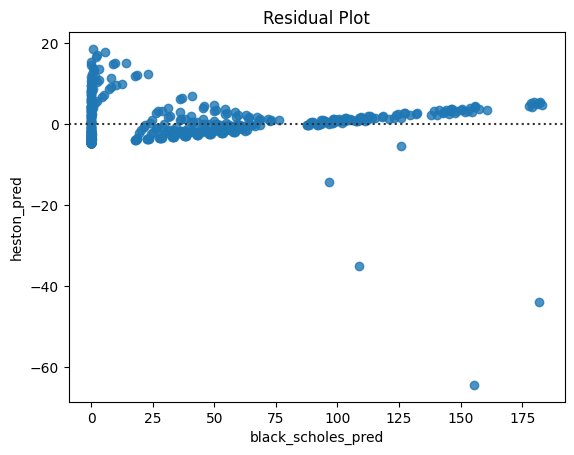

In [18]:
sns.residplot(data=prices_sim, x="black_scholes_pred", y="heston_pred")
plt.title('Residual Plot')
plt.show()

talk about how residuals get crazy around 0, talk about boundaries or something

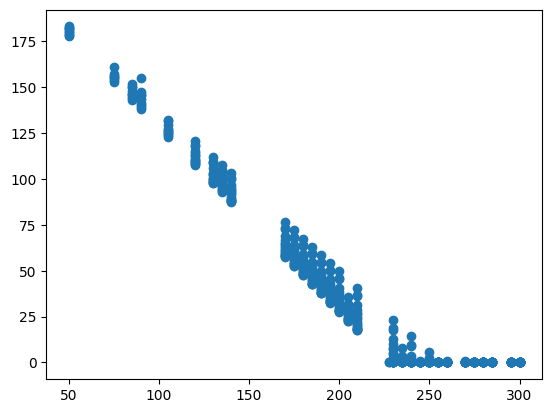

In [31]:
#C vs K
plt.scatter(prices_sim['Strike'], prices_sim['black_scholes_pred'])
#plt.scatter(prices_sim['Strike'], prices_sim['heston_pred'], label='Heston')


In [20]:
call_selected

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
1,AAPL250214C00130000,2025-02-07 16:53:37+00:00,130.0,98.87,0.0,0.0,0.0,0.0,15.0,0.0,0.000010,True,REGULAR,USD,2025-02-14,3,0.008219,Call
2,AAPL250214C00140000,2025-02-07 17:34:59+00:00,140.0,88.52,0.0,0.0,0.0,0.0,36.0,0.0,0.000010,True,REGULAR,USD,2025-02-14,3,0.008219,Call
8,AAPL250214C00170000,2025-02-07 15:17:28+00:00,170.0,60.27,0.0,0.0,0.0,0.0,4.0,0.0,0.000010,True,REGULAR,USD,2025-02-14,3,0.008219,Call
9,AAPL250214C00175000,2025-02-07 18:19:29+00:00,175.0,54.27,0.0,0.0,0.0,0.0,4.0,0.0,0.000010,True,REGULAR,USD,2025-02-14,3,0.008219,Call
10,AAPL250214C00180000,2025-02-07 20:23:42+00:00,180.0,48.40,0.0,0.0,0.0,0.0,11.0,0.0,0.000010,True,REGULAR,USD,2025-02-14,3,0.008219,Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,AAPL270617C00250000,2025-02-07 17:15:08+00:00,250.0,35.00,0.0,0.0,0.0,0.0,13.0,0.0,0.015635,False,REGULAR,USD,2027-06-17,856,2.345205,Call
2017,AAPL270617C00260000,2025-02-07 20:39:56+00:00,260.0,29.45,0.0,0.0,0.0,0.0,1.0,0.0,0.015635,False,REGULAR,USD,2027-06-17,856,2.345205,Call
2018,AAPL270617C00270000,2025-02-07 19:46:42+00:00,270.0,26.23,0.0,0.0,0.0,0.0,5.0,0.0,0.031260,False,REGULAR,USD,2027-06-17,856,2.345205,Call
2019,AAPL270617C00280000,2025-02-07 19:21:52+00:00,280.0,22.50,0.0,0.0,0.0,0.0,8.0,0.0,0.031260,False,REGULAR,USD,2027-06-17,856,2.345205,Call
